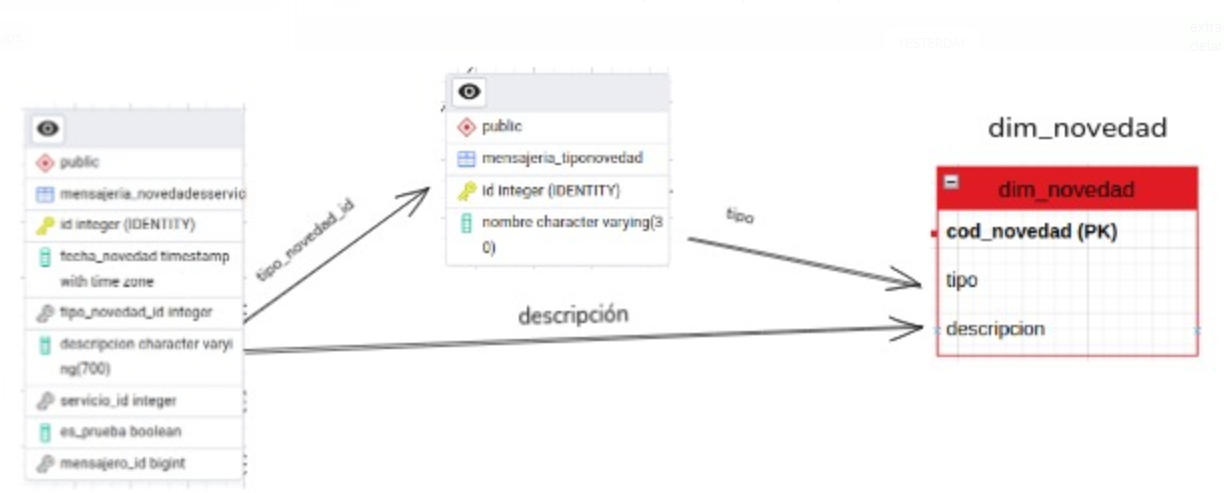

## Importar librerías

In [1]:
# Importar las librerias
import pandas as pd  # Para manipular datos
import sqlalchemy as sa  # Para conectar a la base de datos
import utils.conn_tools as ct  # Para leer la configuración de conexión

## Conexión con base de datos

In [2]:
config = ct.readConfig("../config/config-postgres.yaml")

config_src = config["source"]
config_etl = config["warehouse"]

engine_src = sa.create_engine(ct.generateConnUrl(config_src))
engine_etl = sa.create_engine(ct.generateConnUrl(config_etl))

## Extract

In [3]:
# Leer los datos de las tablas
mensajeria_novedadesservicio_df = pd.read_sql_table(
    "mensajeria_novedadesservicio", con=engine_src
)
mensajeria_tiponovedad_df = pd.read_sql_table("mensajeria_tiponovedad", con=engine_src)

In [ ]:
# Comprobar los campos
mensajeria_novedadesservicio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5208 entries, 0 to 5207
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   id               5208 non-null   int64              
 1   fecha_novedad    5208 non-null   datetime64[ns, UTC]
 2   tipo_novedad_id  5208 non-null   int64              
 3   descripcion      5208 non-null   object             
 4   servicio_id      5208 non-null   int64              
 5   es_prueba        5208 non-null   bool               
 6   mensajero_id     5208 non-null   int64              
dtypes: bool(1), datetime64[ns, UTC](1), int64(4), object(1)
memory usage: 249.3+ KB


In [ ]:
# Comprobar los campos
mensajeria_tiponovedad_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2 non-null      int64 
 1   nombre  2 non-null      object
dtypes: int64(1), object(1)
memory usage: 160.0+ bytes


## Transform: Ajustes de la dimensión

### Realizar JOIN en función del campo tipo_novedad_id

In [6]:
merged_df = mensajeria_novedadesservicio_df.merge(
    mensajeria_tiponovedad_df,
    left_on="tipo_novedad_id", # Campo de mensajeria_novedadesservicio
    right_on="id", # Campo de mensajeria_tiponovedad
    suffixes=("_servicio", "_tipo"), # Sufijos que se agregan al nombre en tabla resultante
)

merged_df = merged_df.drop_duplicates(subset="nombre")
merged_df.head(3)

,id_servicio,fecha_novedad,tipo_novedad_id,descripcion,servicio_id,es_prueba,mensajero_id,id_tipo,nombre
0,4,2023-11-30 05:00:00+00:00,1,A,51,True,7,1,Novedades del servicio
3892,9,2023-11-30 05:00:00+00:00,2,V,51,True,7,2,No puedo continuar


### Extraer solo los campos relevantes

In [7]:
dim_novedad = pd.DataFrame(
    {
        "type": merged_df["nombre"].values,
    }
)

dim_novedad.head(5)

,type
0,Novedades del servicio
1,No puedo continuar


In [8]:
# Create table
metadata = sa.MetaData()

metadata.reflect(bind=engine_etl)  # Reflect helps to get existing tables

dim_novedad_table = sa.Table(
    "dim_novedad",
    metadata,
    # Primary key
    sa.Column("key_novedad", sa.Integer, primary_key=True, autoincrement=True),
    # Dimension keys
    sa.Column("type", sa.String, nullable=False),
)

metadata.create_all(engine_etl)

## Load: Ejecución de ETL

In [9]:
dim_novedad.to_sql(
  name="dim_novedad",
  con=engine_etl,
  if_exists="append",  # Create table if not exists, else append
  index=False,  # Do not create index because we already have one PK
)

2